## Activity 09


The file ```Galaxy_Sample_Logistic.csv``` in the repository includes the following columns for a large sample of galaxies:

> Morph : morphological classification (1= elliptical, 0= everything else)
>
> Density : Log of the environmental density (proportional to the surface density of galaxies around each object)
>
> Absolute : the r band absolute magnitude of an object (remember magnitudes are defined as -2.5log Luminosity)

Using the programming language of your choice:

Visualize and explore the data, discuss if the correlations you see make sense, given what you have learned in class. 
Using the best practice for Bayesian analysis, model the probability $\theta$ of a galaxy being an elliptical as a function of its environmental density and absolute magnitude.

Compute the 95% credibility interval on $\theta$, in the case of  low and high density environments, and for bright and faint galaxies. [You will have to decide what high/low, faint/bright mean here. Make sure you ae quantitative and motivate your choice].

Discuss which variable dominates in determining whether or not a galaxy has an elliptical morphology.


In [51]:
# Import Packages
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [6]:
# Read in the Data
df = pd.read_csv("/Users/abbystokes/Documents/GitHub/AST5731/Activity 10/Galaxy_Sample_Logistic.csv")
df.head()

,Morph,Density,Absolute
0,0.0,-0.618151,-19.978269
1,0.0,0.625710,-21.242310
2,0.0,0.406199,-21.313206
3,1.0,1.250364,-19.582105
4,0.0,-0.575648,-19.507471


In [8]:
# Look at summary
df.describe()

,Morph,Density,Absolute
count,4355.000000,4355.000000,4355.000000
mean,0.251435,0.134801,-20.305943
std,0.433888,0.715290,0.786539
min,0.000000,-1.495605,-22.819994
25%,0.000000,-0.383498,-20.864103
50%,0.000000,0.046150,-20.261288
75%,1.000000,0.600258,-19.668709
max,1.000000,2.740877,-19.000109


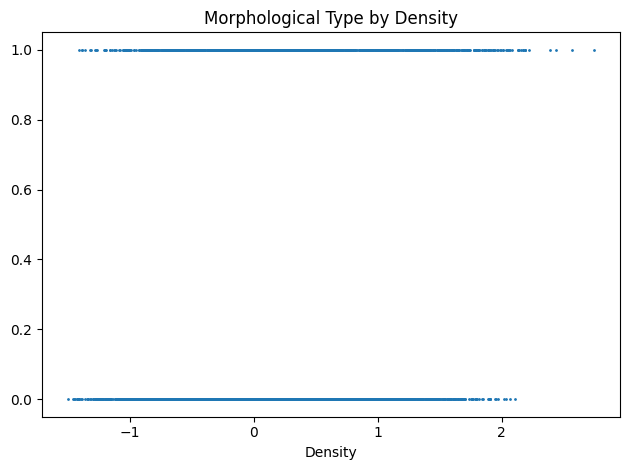

In [32]:
# Visual inspection of data
morph = df['Morph']
dens = df['Density']
mag = df['Absolute']

plt.scatter(dens, morph, s=1)
plt.title("Morphological Type by Density")
plt.xlabel("Density")
plt.tight_layout()

Text(0.5, 0, 'Magnitude')

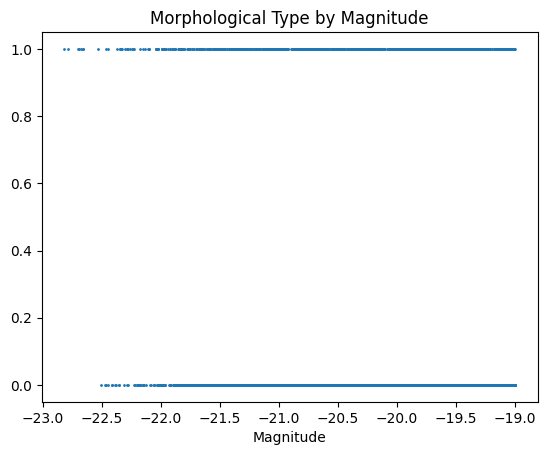

In [22]:
plt.scatter(mag, morph, s=1)
plt.title("Morphological Type by Magnitude")
plt.xlabel("Magnitude")

array([<Axes: title={'center': '0.0'}>, <Axes: title={'center': '1.0'}>],
      dtype=object)

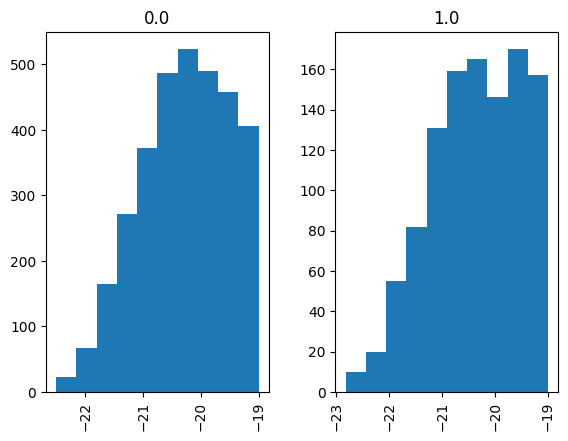

In [30]:
df.hist(column='Absolute', by='Morph')

array([<Axes: title={'center': '0.0'}>, <Axes: title={'center': '1.0'}>],
      dtype=object)

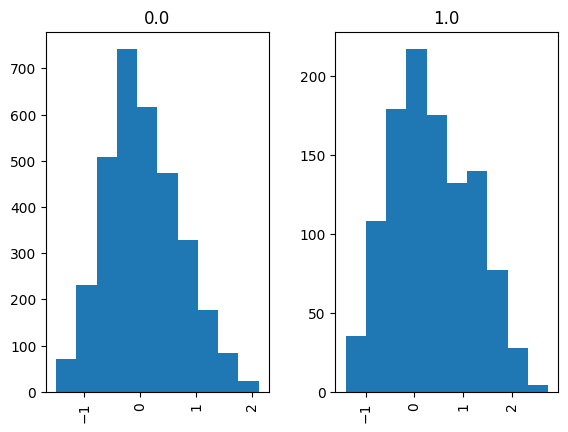

In [31]:
df.hist(column='Density', by='Morph')

Text(0.5, 0, 'Morphological Type')

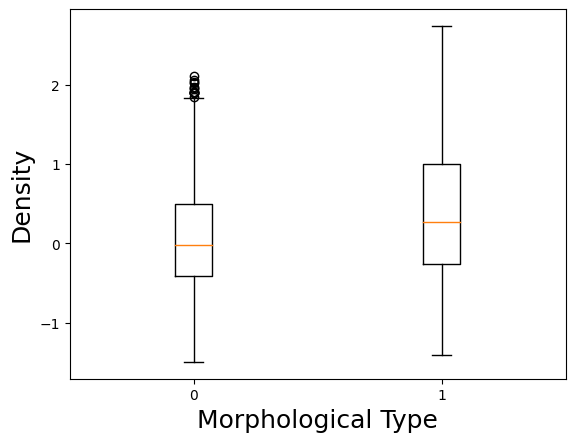

In [36]:
elliptical = df['Morph'] == 1

plt.boxplot(x = [df['Density'][~elliptical], df['Density'][elliptical]], labels = '01')

plt.ylabel('Density', fontsize = 18)
plt.xlabel('Morphological Type', fontsize = 18)

Text(0.5, 0, 'Morphological Type')

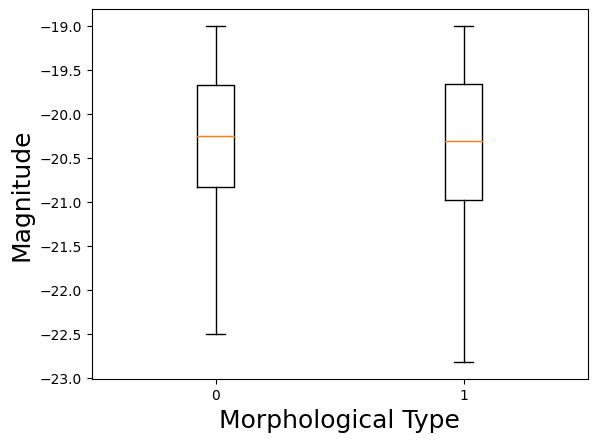

In [37]:
elliptical = df['Morph'] == 1

plt.boxplot(x = [df['Absolute'][~elliptical], df['Absolute'][elliptical]], labels = '01')
plt.ylabel('Magnitude', fontsize = 18)
plt.xlabel('Morphological Type', fontsize = 18)

In [53]:
#MinESS
import pymc as pm
import arviz as az
from scipy.stats import chi2
from scipy.special import gamma

def minESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)

N_sample = minESS(6).astype(int) #We have 6: mean, lb and ub for CI for both b0 and b1

print('Minimum effective size:', N_sample)

Minimum effective size: 8708


In [60]:
# Making the model
y = morph
x1 = dens
x2 = mag

with pm.Model() as model:
    # Beta paramters with reference prior
    beta0 = pm.Normal('beta0', mu=0, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0, tau=0.01, testval=0.0)
    #beta2 = pm.Normal('beta2', mu=0, tau=0.01, testval=0.0)

    # Logistic linking function
    #theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x1+beta2*x2))
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x1))


    # Bernoulli using theta
    observed = pm.Bernoulli('obs',theta,observed=y)
    start=pm.find_MAP()
        #
        # NUTS (Using the Nuts sampler cause I can)
        #
    step = pm.NUTS()
        #
        # Posterior sampling
        #
    trace = pm.sample(N_sample, step=step, return_inferencedata=True);


/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_29431/1869027513.py:8: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=0, tau=0.01, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_29431/1869027513.py:9: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=0, tau=0.01, testval=0.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 1_000 tune and 8_708 draw iterations (4_000 + 34_832 draws total) took 7 seconds.


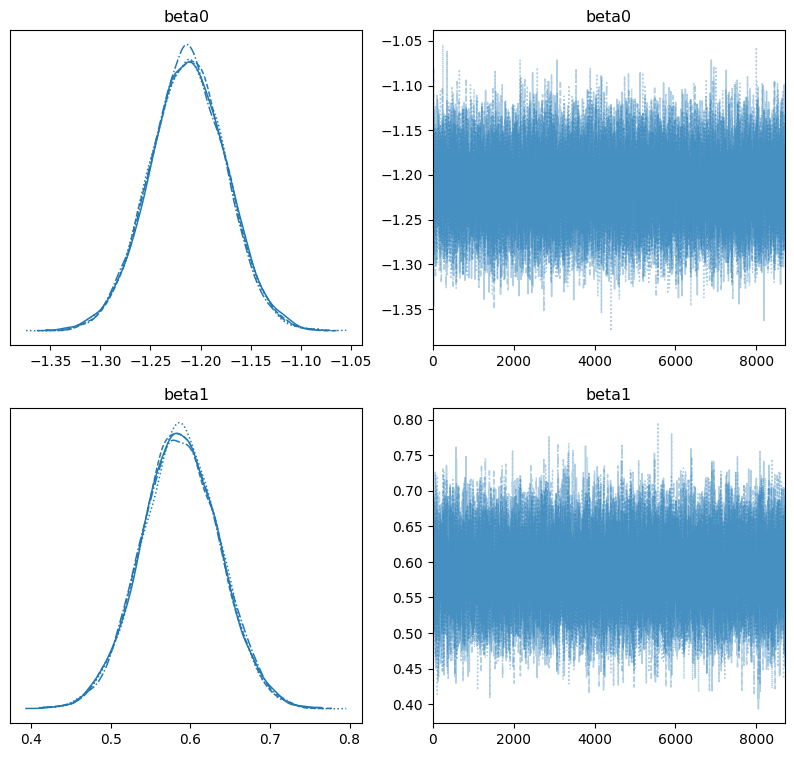

In [61]:
#az.plot_trace(trace,var_names=['beta0','beta1','beta2'],figsize=(10, 9));
az.plot_trace(trace,var_names=['beta0','beta1'],figsize=(10, 9))

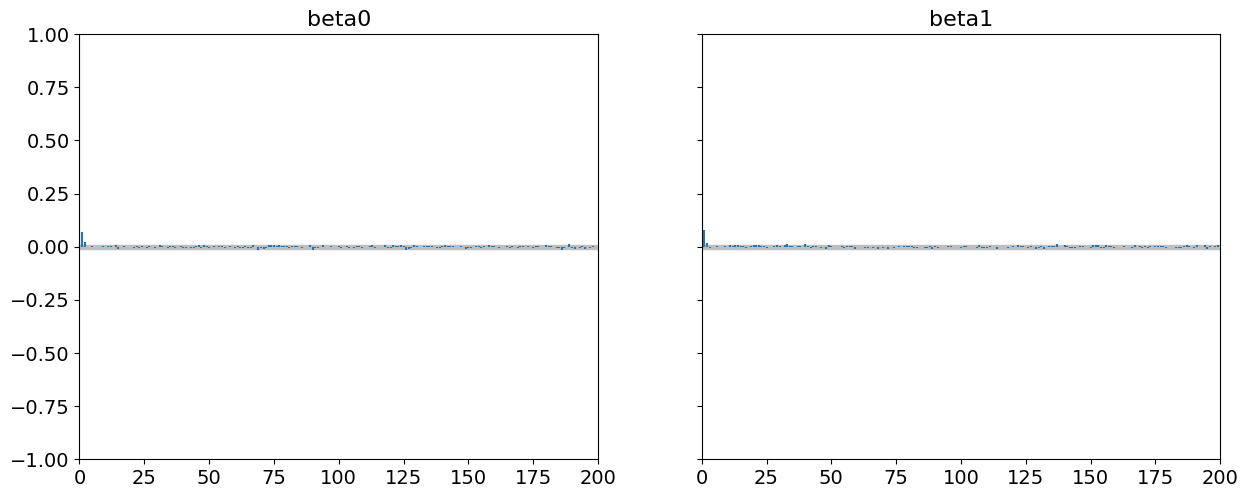

In [65]:
az.plot_autocorr(trace, var_names=['beta0','beta1'],combined=True, max_lag=200);


In [63]:
az.summary(trace, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']]


,mean,hdi_3%,hdi_97%
beta0,-1.2127,-1.2858,-1.1428
beta1,0.5873,0.4976,0.6821


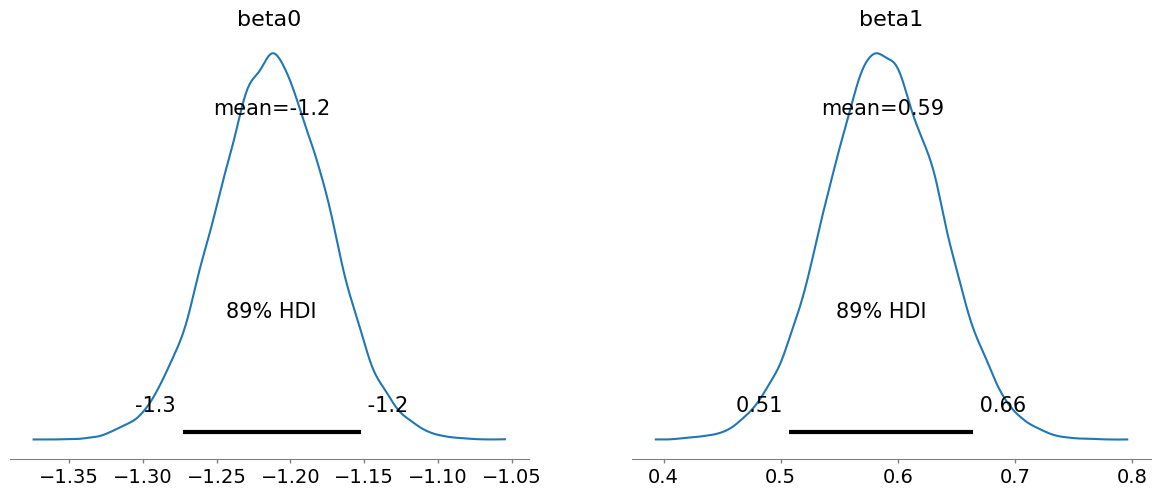

In [64]:
az.plot_posterior(trace, var_names=['beta0','beta1'], hdi_prob=.89);


<Axes: >

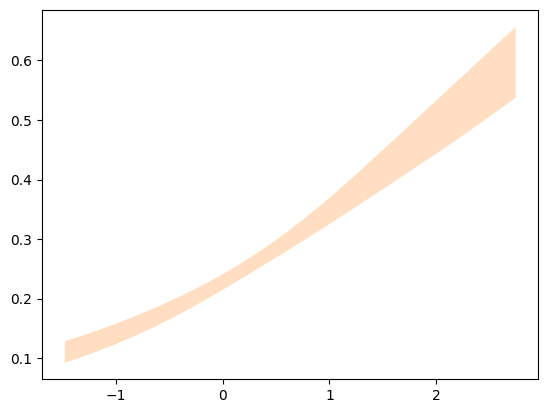

In [67]:
az.plot_hdi(x1,
    trace.posterior.theta,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C1", plot_kwargs={"label":"95% credibility region"}
)